# Homework 6

## Math Tools for Neural and Cognitive Science

Reuben Feinman

11/26/2017

NOTE: grader must have Python bindings for MATLAB installed. See here for details: https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html

In [1]:
from __future__ import division, print_function

import os
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(os.path.realpath('.'),nargout=0)

# Problem #1

In [3]:
def runGaussNoiseExpt(kernel, duration):
    """
    A wrapper function for the matlab function runGaussNoiseExpt.
    Does the necessary data type transformations to the inputs, 
    calls the matlab function, transforms the output back 
    into numpy, and returns.
    """
    kernel_mat = matlab.double(kernel.tolist())
    spikes, stimuli = eng.runGaussNoiseExpt(kernel_mat, duration, nargout=2)
    
    return np.asarray(spikes, dtype=np.bool).reshape(-1,), np.asarray(stimuli, dtype=np.float32)

## (a)

In [58]:
# define the desired kernel
kernel = np.asarray([
    [-1,-2,0],
    [-2,0,2],
    [1,2,0]
])/6.
# divide by norm
kernel /= np.linalg.norm(kernel)
# stretch it out
kernel_1d = kernel.reshape(-1,1)

In [61]:
# call the function
spikes, stimuli = runGaussNoiseExpt(kernel_1d, 100)
# compute the linear filter response to the stimuli
stimuli_responses = np.matmul(stimuli, kernel_1d)

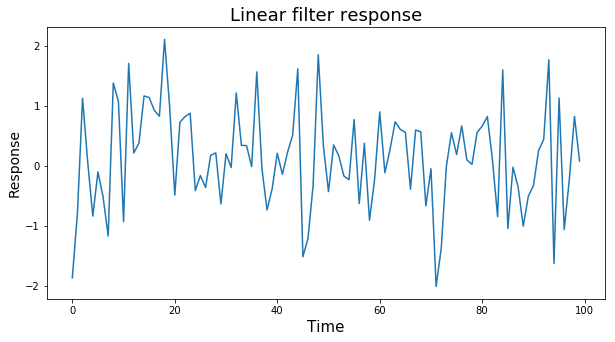

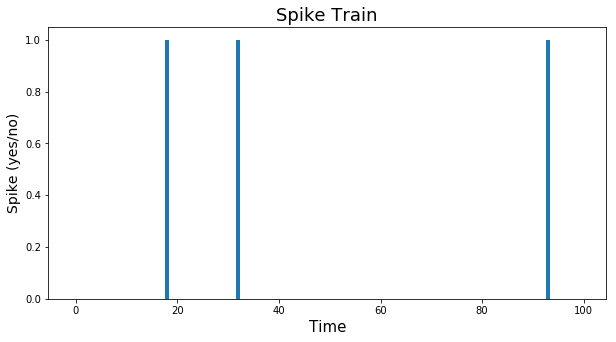

In [62]:
# Plot filter response
plt.figure(figsize=(10,5))
plt.plot(range(100),stimuli_responses)
plt.title('Linear filter response', fontsize=18)
plt.ylabel('Response', fontsize=14)
plt.xlabel('Time', fontsize=15)
plt.show()
# Plot spike train
plt.figure(figsize=(10,5))
plt.bar(range(100),spikes)
plt.title('Spike Train', fontsize=18)
plt.ylabel('Spike (yes/no)', fontsize=14)
plt.xlabel('Time', fontsize=15)
plt.show()

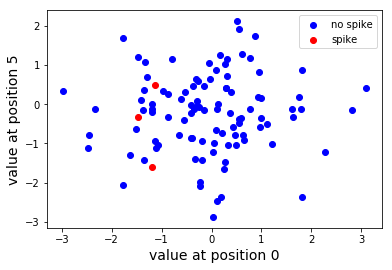

In [74]:
# Display 2D scatter plot of raw stimulus values at positions 
# 0 and 5 (translated from 1 and 6 for Python)
plt.figure()
plt.scatter(stimuli[:,0], stimuli[:,5], color='blue', label='no spike')
# get indices where spikes occured
spike_inds = np.where(spikes)[0]
plt.scatter(stimuli[spike_inds,0], stimuli[spike_inds,1], color='red', label='spike')
plt.xlabel('value at position 0', fontsize=14)
plt.ylabel('value at position 5', fontsize=14)
plt.legend()
plt.show()

In [77]:
list(enumerate(kernel_1d.reshape(-1)))

[(0, -0.23570226039551581),
 (1, -0.47140452079103162),
 (2, 0.0),
 (3, -0.47140452079103162),
 (4, 0.0),
 (5, 0.47140452079103162),
 (6, 0.23570226039551581),
 (7, 0.47140452079103162),
 (8, 0.0)]

It appears that spikes occur at negative values for position 0 and near-0 values for position 5. The results for position 0 make sense: the kernel has a negative value there. The results for position 5 are less intuitive: the kernel has a positive value there, so we'd expect to see the values be positive. It could be that the other dimensions had a greater affect on the spiking decision for these points.

## (b)

In [78]:
# Compute the sta
nb_spikes = 0
sta = np.zeros((9,))
for i in range(100):
    if spikes[i]:
        nb_spikes += 1
        sta += stimuli[i]
sta /= nb_spikes 

# rescale it to have unit norm
sta /= np.linalg.norm(sta)

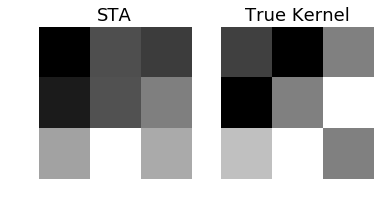

In [79]:
# Display normalized STA as a grayscale image alongside
# the ground truth kernel
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
axes[0].imshow(sta.reshape(3,3), cmap='gray')
axes[0].set_title('STA', fontsize=18)
axes[0].axis('off')
axes[1].imshow(kernel.reshape(3,3), cmap='gray')
axes[1].set_title('True Kernel', fontsize=18)
axes[1].axis('off')
plt.show()

The STA and the true kernel look very simlar - they both have large values at bottom center and right center, and both have very small value at left center.

In [80]:
# For the STA error vs. duration experiment, I will first
# write a function to compute the normalized STA
def compute_sta(spikes, stimuli):
    nb_spikes = 0
    sta = np.zeros((9,))
    for i in range(100):
        if spikes[i]:
            nb_spikes += 1
            sta += stimuli[i]
    sta /= nb_spikes
    
    return sta

In [43]:
# Now, step through the durations and compute STAs for each,
# computing error each time
durations = np.array([100, 200, 400, 800, 1600, 3200, 6400])
# pre-allocate space for error values
errors = np.zeros_like(durations, dtype=np.float32)
variances = np.zeros_like(durations, dtype=np.float32)
for i, dur in enumerate(durations):
    sta_vals = []
    for j in range(100):
        # run the experiment
        spikes, stimuli = runGaussNoiseExpt(kernel_1d, int(dur))
        if np.where(spikes)[0].shape[0] > 0:
            # if at least one spike occured, this run should
            # contribute to our average. Compute STA...
            sta = compute_sta(spikes, stimuli)
            # sometimes we get NANs. These ruin our computation. 
            # Let's ignore them.
            if not np.isnan(sta).any():
                sta_vals.append(sta)
    sta_vals = np.asarray(sta_vals)
    sta_avg = np.mean(sta_vals, axis=0)
    sta_var = np.var(sta_vals, axis=0)
    # compute the error
    errors[i] = np.linalg.norm(sta_avg - kernel.reshape(9,), ord=1)
    variances[i] = np.mean(sta_var)
    print('duration: %i,\terror: %0.2f,\tvariance: %0.2f' % (dur, errors[i], variances[i]))

duration: 100,	error: 2.43,	variance: 0.31


/Users/reubenfeinman/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


duration: 200,	error: 2.29,	variance: 0.37
duration: 400,	error: 2.42,	variance: 0.33
duration: 800,	error: 2.64,	variance: 0.37
duration: 1600,	error: 2.52,	variance: 0.36
duration: 3200,	error: 2.45,	variance: 0.32
duration: 6400,	error: 2.44,	variance: 0.35


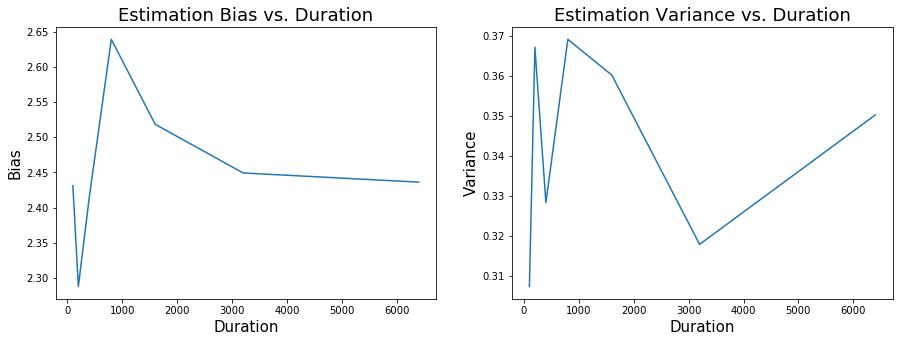

In [52]:
# plot bias and variance as function of duration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(durations, errors)
axes[0].set_title('Estimation Bias vs. Duration', fontsize=18)
axes[0].set_xlabel('Duration', fontsize=15)
axes[0].set_ylabel('Bias', fontsize=15)
axes[1].plot(durations, variances)
axes[1].set_title('Estimation Variance vs. Duration', fontsize=18)
axes[1].set_xlabel('Duration', fontsize=15)
axes[1].set_ylabel('Variance', fontsize=15)
plt.show()

The bias and variance both seem to show a dampened oscillation. There is no clear monotonic trend in either case, although the bias seems to flatten out and reach an asymptote around 2.45.

## (c)

In [53]:
def runBinNoiseExpt(kernel, duration):
    """
    A wrapper function for the matlab function runBinNoiseExpt.
    """
    kernel_mat = matlab.double(kernel.tolist())
    spikes, stimuli = eng.runBinNoiseExpt(kernel_mat, duration, nargout=2)
    
    return np.asarray(spikes, dtype=np.bool).reshape(-1,), np.asarray(stimuli, dtype=np.float32)

In [55]:
# Now, step through the durations and compute STAs for each,
# computing error each time
durations = np.array([100, 200, 400, 800, 1600, 3200, 6400])
#durations = np.array([100, 200, 400, 800])
# pre-allocate space for error values
errors = np.zeros_like(durations, dtype=np.float32)
variances = np.zeros_like(durations, dtype=np.float32)
for i, dur in enumerate(durations):
    sta_vals = []
    for j in range(100):
        # run the experiment
        spikes, stimuli = runBinNoiseExpt(kernel_1d, int(dur))
        if np.where(spikes)[0].shape[0] > 0:
            # if at least one spike occured, this run should
            # contribute to our average. Compute STA...
            sta = compute_sta(spikes, stimuli)
            # sometimes we get NANs. These ruin our computation. 
            # Let's ignore them.
            if not np.isnan(sta).any():
                sta_vals.append(sta)
    sta_vals = np.asarray(sta_vals)
    sta_avg = np.mean(sta_vals, axis=0)
    sta_var = np.var(sta_vals, axis=0)
    # compute the error
    errors[i] = np.linalg.norm(sta_avg - kernel.reshape(9,), ord=1)
    variances[i] = np.mean(sta_var)
    print('duration: %i,\terror: %0.2f,\tvariance: %0.2f' % (dur, errors[i], variances[i]))

duration: 100,	error: 2.29,	variance: 0.23


/Users/reubenfeinman/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


duration: 200,	error: 2.41,	variance: 0.22
duration: 400,	error: 2.25,	variance: 0.21
duration: 800,	error: 2.31,	variance: 0.21
duration: 1600,	error: 2.22,	variance: 0.23
duration: 3200,	error: 2.26,	variance: 0.23
duration: 6400,	error: 2.27,	variance: 0.25


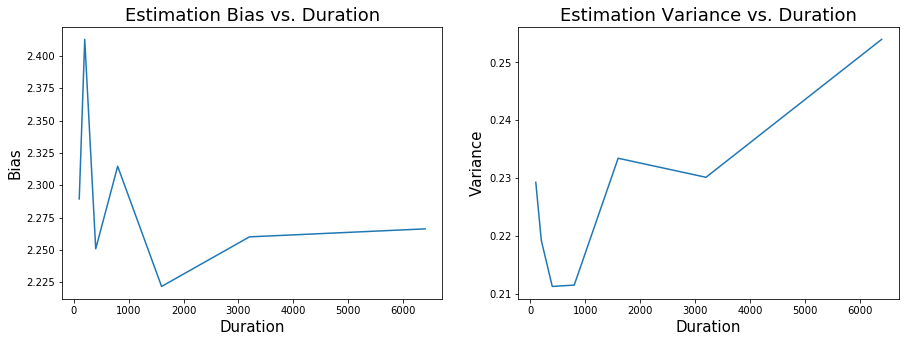

In [56]:
# plot bias and variance as function of duration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(durations, errors)
axes[0].set_title('Estimation Bias vs. Duration', fontsize=18)
axes[0].set_xlabel('Duration', fontsize=15)
axes[0].set_ylabel('Bias', fontsize=15)
axes[1].plot(durations, variances)
axes[1].set_title('Estimation Variance vs. Duration', fontsize=18)
axes[1].set_xlabel('Duration', fontsize=15)
axes[1].set_ylabel('Variance', fontsize=15)
plt.show()

Here, the bias plot again looks like a dampened oscillation. This time, however, rather than just dampening the oscillation amplitude, the mean is also shifted downward with increased duration. This makes sense because binary noise causes bias, so we should need a higher duration to get an unbiased estimate. The variance seems to increase, generally, with greater duration here.

# Problem #2